--- 🧠 ANÁLISE DE INTELIGÊNCIA DE DADOS (AURUM V4) ---

📊 Dimensões: 18879 linhas x 58 colunas
📅 Período: 2012-03-31 até 2025-12-31
🏢 Tickers Únicos: 94

📰 Cobertura de Notícias:
   - Linhas com Notícias: 179 (0.95%)
   - Linhas 'Cegas' (Sem news): 18700

🔗 Matriz de Correlação (Fatores vs Retorno Futuro):
                     NEXT_RET
NEXT_RET             1.000000
aurum_quality_score  0.019950
NEWS_VOLUME          0.014428
ROE                  0.012623
SENTIMENT_SCORE      0.001099


C:\Users\kaike\AppData\Local\Temp\ipykernel_12572\2998125755.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_com_news['SENTIMENT_RANK'] = pd.qcut(df_com_news['SENTIMENT_SCORE'], 5, labels=["Muito Neg", "Neg", "Neutro", "Pos", "Muito Pos"], duplicates='drop')
C:\Users\kaike\AppData\Local\Temp\ipykernel_12572\2998125755.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_com_news, x='SENTIMENT_RANK', y='NEXT_RET', palette='RdYlGn')
C:\Users\kaike\AppData\Local\Temp\ipykernel_12572\2998125755.py:73: FutureWarning: 'M' is deprecated and will be removed in a future version, please use '


💾 Gráfico de análise salvo em: ../data/reports/analise_final_v4.png


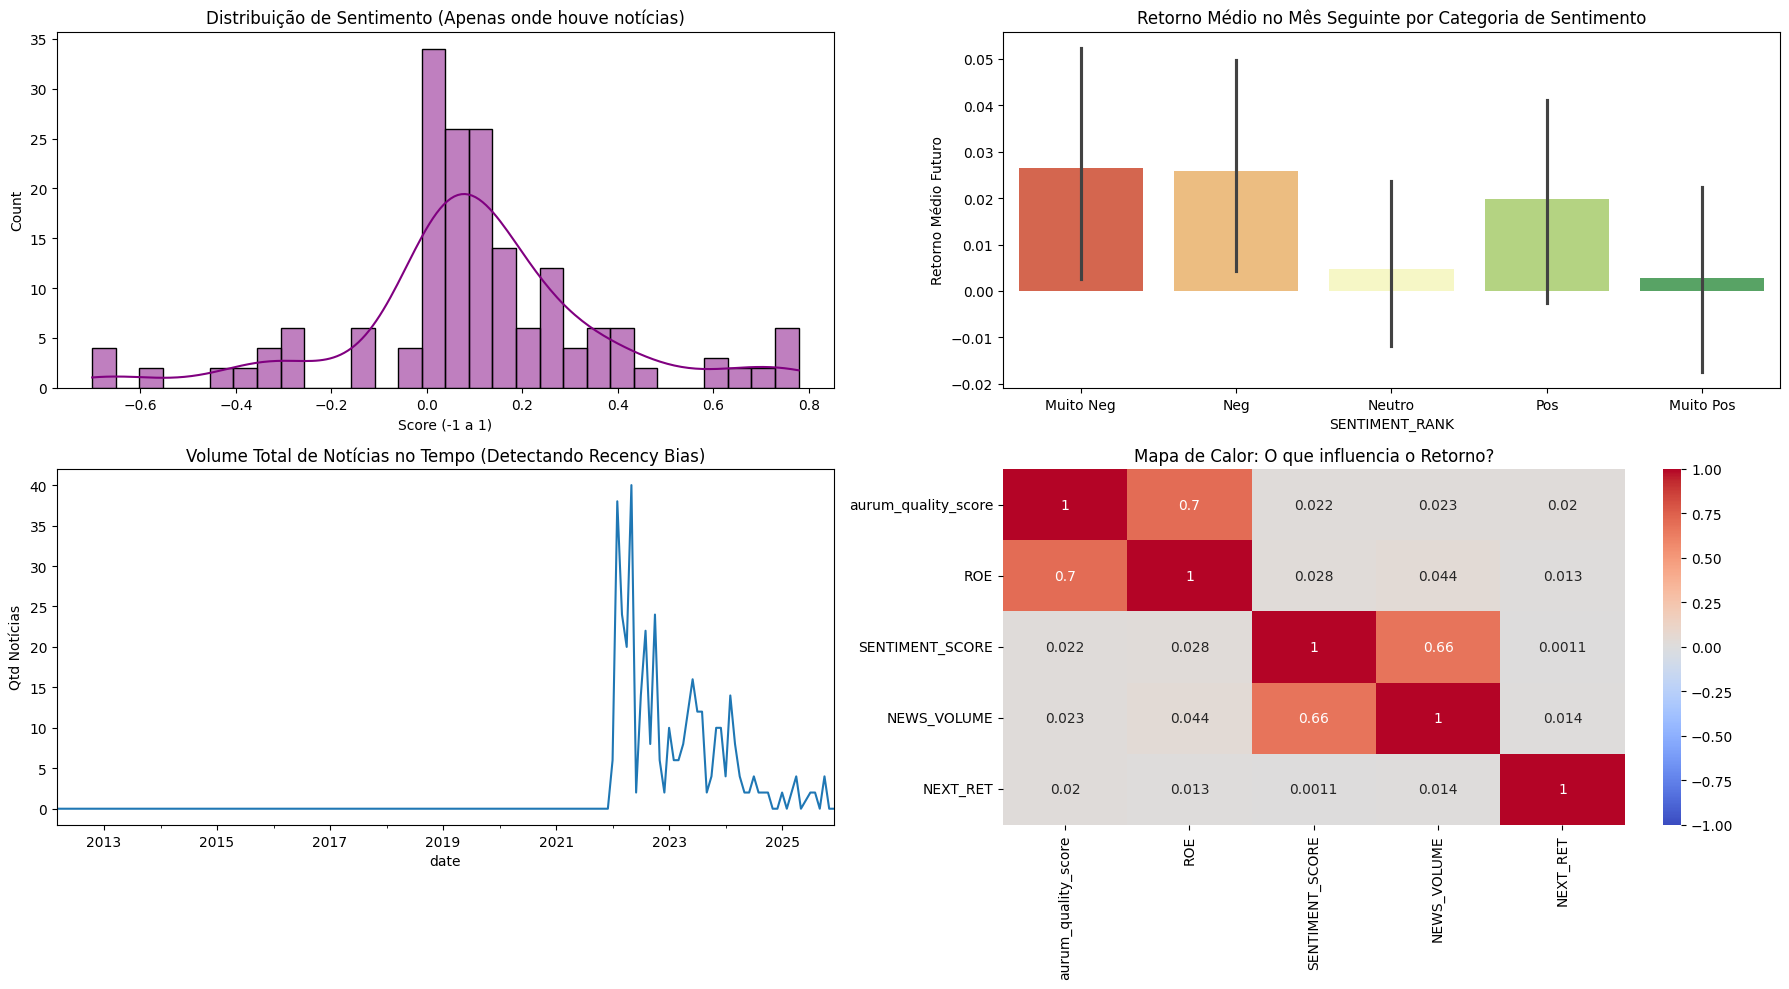


🏆 Top 5 Ações com Melhor Sentimento Recente (Com Volume Relevante):
⚠️ Nenhuma ação com volume >= 2 notícias na última data.


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

INPUT_FILE = "../data/aurum_master_features_final.parquet"
OUTPUT_DIR = "../data/reports"

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

def carregar_dados():
    if not os.path.exists(INPUT_FILE):
        print(f"❌ Arquivo não encontrado: {INPUT_FILE}")
        return None
    
    df = pd.read_parquet(INPUT_FILE)
    df['date'] = pd.to_datetime(df['date'])
    return df

def analise_financeira(df):
    print("--- 🧠 ANÁLISE DE INTELIGÊNCIA DE DADOS (AURUM V4) ---")
    
    df = df.sort_values(['ticker', 'date'])
    df['NEXT_RET'] = df.groupby('ticker')['Adj Close'].pct_change().shift(-1)
    
    print(f"\n📊 Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    print(f"📅 Período: {df['date'].min().date()} até {df['date'].max().date()}")
    print(f"🏢 Tickers Únicos: {df['ticker'].nunique()}")
    
    df_com_news = df[df['NEWS_VOLUME'] > 0]
    cob = len(df_com_news) / len(df) * 100
    print(f"\n📰 Cobertura de Notícias:")
    print(f"   - Linhas com Notícias: {len(df_com_news)} ({cob:.2f}%)")
    print(f"   - Linhas 'Cegas' (Sem news): {len(df) - len(df_com_news)}")
    
    print("\n🔗 Matriz de Correlação (Fatores vs Retorno Futuro):")
    cols_corr = ['aurum_quality_score', 'ROE', 'SENTIMENT_SCORE', 'NEWS_VOLUME', 'NEXT_RET']
    cols_corr = [c for c in cols_corr if c in df.columns]
    
    corr = df[cols_corr].corr(method='spearman') 
    print(corr[['NEXT_RET']].sort_values('NEXT_RET', ascending=False))

    plt.figure(figsize=(18, 10))
    
    plt.subplot(2, 2, 1)
    sns.histplot(df_com_news['SENTIMENT_SCORE'], kde=True, color='purple', bins=30)
    plt.title('Distribuição de Sentimento (Apenas onde houve notícias)')
    plt.xlabel('Score (-1 a 1)')
    
    plt.subplot(2, 2, 2)
    if not df_com_news.empty:
        df_com_news['SENTIMENT_RANK'] = pd.qcut(df_com_news['SENTIMENT_SCORE'], 5, labels=["Muito Neg", "Neg", "Neutro", "Pos", "Muito Pos"], duplicates='drop')
        sns.barplot(data=df_com_news, x='SENTIMENT_RANK', y='NEXT_RET', palette='RdYlGn')
        plt.title('Retorno Médio no Mês Seguinte por Categoria de Sentimento')
        plt.ylabel('Retorno Médio Futuro')
    
    plt.subplot(2, 2, 3)
    df.set_index('date').resample('M')['NEWS_VOLUME'].sum().plot()
    plt.title('Volume Total de Notícias no Tempo (Detectando Recency Bias)')
    plt.ylabel('Qtd Notícias')
    
    plt.subplot(2, 2, 4)
    sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Mapa de Calor: O que influencia o Retorno?')
    
    plt.tight_layout()
    img_path = f"{OUTPUT_DIR}/analise_final_v4.png"
    plt.savefig(img_path)
    print(f"\n💾 Gráfico de análise salvo em: {img_path}")
    plt.show()
    
    print("\n🏆 Top 5 Ações com Melhor Sentimento Recente (Com Volume Relevante):")
    last_date = df['date'].max()
    df_last = df[df['date'] == last_date].copy()
    df_picks = df_last[df_last['NEWS_VOLUME'] >= 2].sort_values('SENTIMENT_SCORE', ascending=False)
    
    if not df_picks.empty:
        print(df_picks[['ticker', 'Adj Close', 'SENTIMENT_SCORE', 'NEWS_VOLUME']].head(5).to_string())
    else:
        print("⚠️ Nenhuma ação com volume >= 2 notícias na última data.")

if __name__ == "__main__":
    df = carregar_dados()
    if df is not None:
        analise_financeira(df)

In [1]:
import pandas as pd
import numpy as np
import os

# --- CONFIGURAÇÃO ---
FILE_PATH = "../data/aurum_final_scores/aurum_scored_history.parquet"

def analisar_dataset():
    print(f"🔬 INICIANDO RAIO-X DO ARQUIVO: {FILE_PATH}\n")
    
    if not os.path.exists(FILE_PATH):
        print("❌ Arquivo não encontrado! Rode o step_08_scoring_engine_final.py primeiro.")
        return

    # 1. Carregamento
    try:
        df = pd.read_parquet(FILE_PATH)
    except Exception as e:
        print(f"❌ Erro ao abrir arquivo: {e}")
        return

    # 2. Visão Geral
    print("--- 1. ESTRUTURA ---")
    print(f"Linhas:   {df.shape[0]}")
    print(f"Colunas:  {df.shape[1]}")
    print(f"\nLista de Colunas: \n{list(df.columns)}")
    
    # 3. Tipos de Dados (Crucial para o Backtrader)
    print("\n--- 2. TIPOS DE DADOS (Dtypes) ---")
    print(df.dtypes)
    
    # Verifica se colunas vitais são numéricas
    cols_vitais = ['Adj Close', 'aurum_quality_score']
    for col in cols_vitais:
        if col in df.columns:
            is_numeric = pd.api.types.is_numeric_dtype(df[col])
            status = "✅ Numérico" if is_numeric else "⚠️ ALERTA: NÃO NUMÉRICO"
            print(f"   -> {col}: {status}")

    # 4. Análise de Nulos (Buracos no Queijo)
    print("\n--- 3. VERIFICAÇÃO DE NULOS ---")
    nulos = df.isnull().sum()
    nulos = nulos[nulos > 0]
    if nulos.empty:
        print("✅ Nenhum valor nulo encontrado! Dataset blindado.")
    else:
        print(nulos)

    # 5. Estatísticas do Score Aurum
    print("\n--- 4. ESTATÍSTICAS DO SCORE AURUM ---")
    if 'aurum_quality_score' in df.columns:
        desc = df['aurum_quality_score'].describe()
        print(desc)
        print(f"\n   Média: {desc['mean']:.2f}")
        print(f"   Mínimo: {desc['min']:.2f}")
        print(f"   Máximo: {desc['max']:.2f}")
    
    # 6. Amostra Visual
    print("\n--- 5. AMOSTRA (HEAD) ---")
    cols_view = ['date', 'ticker', 'Adj Close', 'aurum_quality_score', 'quality_grade']
    # Filtra apenas colunas que existem
    cols_view = [c for c in cols_view if c in df.columns]
    print(df[cols_view].head(5).to_string())

    print("\n--- 6. AMOSTRA (TAIL) ---")
    print(df[cols_view].tail(5).to_string())

if __name__ == "__main__":
    analisar_dataset()

🔬 INICIANDO RAIO-X DO ARQUIVO: ../data/aurum_final_scores/aurum_scored_history.parquet

--- 1. ESTRUTURA ---
Linhas:   18879
Colunas:  62

Lista de Colunas: 
['date', 'ticker', 'Adj Close', 'CNPJ_CIA', 'DENOM_CIA', 'date_balanco', 'Custo dos Bens e/ou Serviços Vendidos', 'EBIT', 'EBT', 'Lucro Bruto', 'Lucro Líquido Consolidado', 'Receita Líquida', 'Ativo Circulante', 'Ativo Não Circulante', 'Ativo Total', 'Caixa e Equivalentes', 'Dívida Curto Prazo', 'Dívida Longo Prazo', 'Passivo Circulante', 'Passivo Não Circulante', 'Passivo Total', 'Patrimônio Líquido Consolidado', 'Receita Líquida_ttm', 'Custo dos Bens e/ou Serviços Vendidos_ttm', 'Lucro Bruto_ttm', 'EBIT_ttm', 'EBT_ttm', 'Lucro Líquido Consolidado_ttm', 'Dívida Bruta', 'Capital Investido', 'Dívida Líquida', 'ROE', 'ROA', 'ROIC', 'MARGEM_EBIT', 'MARGEM_LIQUIDA', 'MARGEM_BRUTA', 'ALAVANCAGEM', 'DIVIDA_PL', 'DIVIDA_LIQ_EBIT', 'LIQUIDEZ_CORRENTE', 'GIRO_ATIVO', 'score_ROIC', 'score_ROE', 'score_MARGEM_EBIT', 'score_MARGEM_LIQUIDA', '